# Finding the right model

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

from xgboost import XGBClassifier
from xgboost import plot_importance

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import load_OU_data, CourseScaler, plot_confusion, score_grid, \
smotecourses, process_courses, course_cross_validate, Course_GridSearchCV, \
model_evaluate_presentation, cross_val_presentation, GridSearchPresentationCV

import pickle

import warnings

from IPython.display import display

warnings.filterwarnings("ignore")
sns.set_style('white')
pd.set_option('display.max_columns',None)

In [2]:
df_full = load_OU_data(prediction_window=.5)


In [3]:
df = df_full.copy()
df = df.drop(columns = ['id_student','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration'])
df['final_result'] = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in df['final_result']])
test_df = df[df['code_presentation'] == '2014J']
train_df = df[df['code_presentation'] != '2014J']

X_train = train_df.drop(columns = ['final_result','code_presentation'])
y_train = train_df['final_result']
X_test = test_df.drop(columns = ['final_result','code_presentation'])
y_test = test_df['final_result']

X_train_transformed, y_train_transformed, X_test_transformed \
                                = process_courses(X_train, y_train, X_test)

0.7736615241958952

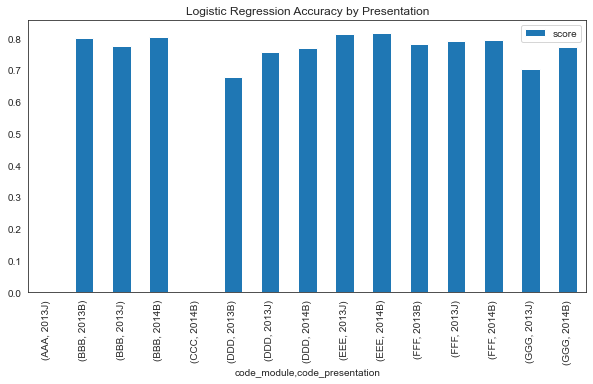

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.801174
            2013J              0.776324
            2014B              0.803556
CCC         2014B                   NaN
DDD         2013B              0.678986
            2013J              0.756466
            2014B              0.770686
EEE         2013J              0.812958
            2014B              0.815838
FFF         2013B              0.782291
            2013J              0.790545
            2014B              0.793852
GGG         2013J              0.702315
            2014B               0.77261

In [6]:

model = LogisticRegression()
scores = cross_val_presentation(model, train_df, scoring = 'f1', verbose = 1)
scores.plot(kind = 'bar', figsize = (10,5), title = 'Logistic Regression Accuracy by Presentation')
plt.show()
display(scores)

In [ ]:
model = XGBClassifier()
cross_val_presentation(model, df, show_scores = False, show_progress = True)

In [ ]:
model = pickle.load(open('../models/XGBmodel4.pkl','rb'))
cross_val_presentation(model, df, show_scores = False, show_progress = True)

## GridsearchCV for best logistic regression hyperparameters

trying:
{'penalty': 'none', 'random_state': 111, 'solver': 'lbfgs'}
average score:  0.7736157638883859
trying:
{'penalty': 'none', 'random_state': 111, 'solver': 'sag'}
average score:  0.7736157638883859
trying:
{'penalty': 'none', 'random_state': 111, 'solver': 'saga'}
average score:  0.7736157638883859
trying:
{'penalty': 'none', 'random_state': 111, 'solver': 'newton-cg'}
average score:  0.7736157638883859
trying:
{'penalty': 'l2', 'random_state': 111, 'solver': 'lbfgs'}
average score:  0.7736615241958952
trying:
{'penalty': 'l2', 'random_state': 111, 'solver': 'sag'}
average score:  0.7736615241958952
trying:
{'penalty': 'l2', 'random_state': 111, 'solver': 'saga'}
average score:  0.7736615241958952
trying:
{'penalty': 'l2', 'random_state': 111, 'solver': 'newton-cg'}
average score:  0.7736615241958952
trying:
{'penalty': 'l2', 'random_state': 111, 'solver': 'liblinear'}
average score:  0.7736615241958952
trying:
{'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
average 

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.801174
            2013J              0.776324
            2014B              0.803556
CCC         2014B                   NaN
DDD         2013B              0.678986
            2013J              0.756466
            2014B              0.770686
EEE         2013J              0.812958
            2014B              0.815838
FFF         2013B              0.782291
            2013J              0.790545
            2014B              0.793852
GGG         2013J              0.702315
            2014B               0.77261

cross validated accuracy score:
0.7736615241958952
validation accuracy: 
0.7030264817150063
validation set confusion matrix


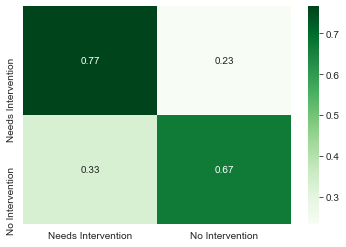

In [7]:
LRparams = [{'solver': ['lbfgs','sag','saga','newton-cg'],
         'penalty': ['none'],
         'random_state':[111]},
          {'solver': ['lbfgs','sag','saga','newton-cg','liblinear'],
         'penalty': ['l2'],
         'random_state':[111]},
          {'solver':['saga'],
          'penalty':['elasticnet'], 'l1_ratio':[.1,.5,.7]},
          {'solver':['saga','liblinear'],
          'penalty':['l1']}]


LRgrid = GridSearchPresentationCV(LogisticRegression(), LRparams,
                                scoring='f1', verbose = 1)

LRgrid.fit(train_df)
LRmodel = score_grid(LRgrid, X_test_transformed, y_test)
# pickle.dump(LRmodel,open('../models/LRmodel2.pkl','wb'))

## Logistic Regression Evaluation
By optimizing the hyperparameters of the logistic regression model, which are all regularization parameters, we've barely moved the needle at all.  We gained .0002 accuracy.

# More model types
We used the logistic regression classifier to tune our features, but now it's time to try some other models.  We will use Course_GridsearchCV to optimize the hyperparameters for these as well.

# Decision Tree
A decision tree is a promising candidate for this problem because it does not assume the independence of the features. Instead it seeks to find the best way to divide and subdivide the data in a tree structure based on the values of different variables.  We can tune how many features each split is allowed to consider.  Once the tree is build predictions are made by sending an observations down the tree sending it on a path to the predicted class as it reaches each split in the tree is sent in one or the other direction.  You can think of it like a deterministic Pachinko machine!

trying:
{'criterion': 'gini', 'max_depth': 4, 'max_features': 1, 'min_samples_split': 0.01, 'random_state': 111, 'splitter': 'best'}
average score:  0.7573507758771403
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_features': 1, 'min_samples_split': 0.1, 'random_state': 111, 'splitter': 'best'}
average score:  0.7503945891139996
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_features': 1, 'min_samples_split': 0.2, 'random_state': 111, 'splitter': 'best'}
average score:  0.7108833489073808
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_features': 1, 'min_samples_split': 0.5, 'random_state': 111, 'splitter': 'best'}
average score:  0.7375664073944248
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_features': 2, 'min_samples_split': 0.01, 'random_state': 111, 'splitter': 'best'}
average score:  0.7463046420062983
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_features': 2, 'min_samples_split': 0.1, 'random_state': 111, 'splitter': 'best'}
average score:  0.7451316588610

average score:  0.7784164156947414
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 3, 'min_samples_split': 0.1, 'random_state': 111, 'splitter': 'best'}
average score:  0.7840705492092734
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 3, 'min_samples_split': 0.2, 'random_state': 111, 'splitter': 'best'}
average score:  0.7468795580707434
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 3, 'min_samples_split': 0.5, 'random_state': 111, 'splitter': 'best'}
average score:  0.7592921987660736
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'min_samples_split': 0.01, 'random_state': 111, 'splitter': 'best'}
average score:  0.7743654856668734
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'min_samples_split': 0.1, 'random_state': 111, 'splitter': 'best'}
average score:  0.7855931789321768
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'min_samples_split': 0.2, 'random_state': 111,

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.796038
            2013J              0.784652
            2014B              0.756139
CCC         2014B                   NaN
DDD         2013B              0.761352
            2013J              0.788075
            2014B              0.806147
EEE         2013J              0.838631
            2014B              0.823204
FFF         2013B              0.800975
            2013J              0.793537
            2014B              0.792948
GGG         2013J              0.710033
            2014B              0.760982

cross validated accuracy score:
0.7855931789321768
validation accuracy: 
0.6733921815889029
validation set confusion matrix


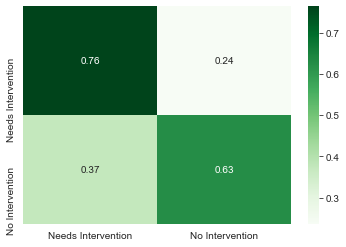

In [8]:
DTparams = {'criterion':['gini','entropy'],
           'splitter':['best'],
           'max_depth':[4,10],'min_samples_split':[.01,.1,.2,.5],
           'max_features':[1,2,3,4,5],'random_state':[111]}


DTgrid = GridSearchPresentationCV(DecisionTreeClassifier(), DTparams,
                                scoring='f1', verbose = 1)

DTgrid.fit(train_df)
DTmodel = score_grid(DTgrid, X_test_transformed, y_test)
# pickle.dump(DTmodel,open('../models/DTmodel2.pkl','wb'))

### Decision Tree Evaluation 
As expected, this model is better at predicting how a student will do.  It doesn't rely on establishing a straight line through the data to model it, which is probably not the best approach in this problem space.  We see a nice increase in accuracy here.

# Random Forest Classifier
This is an interesting extension to the decision tree model.  It creates a whole forest of decision trees and trains each one on a subset of the data and a subset of the features.  This is a technique called bagging, or [Boostrap AGGregation](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/) (check the link for more on this).  It works on the principle that a bunch of bad predictors, on average will be more accurate than one good predictor.  This worked for Francis Galton in [guessing the weight of an ox](https://crowdsourcingweek.com/blog/using-the-crowd-to-predict/), maybe it will work here!

trying:
{'criterion': 'gini', 'max_depth': 4, 'max_samples': 0.5, 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': True, 'random_state': 111}
average score:  0.7866743083130603
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_samples': 0.5, 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': 111}
average score:  0.7866743083130603
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_samples': 0.5, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 111}
average score:  0.7882808498142785
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_samples': 0.5, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 111}
average score:  0.7882808498142785
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_samples': 0.5, 'min_samples_split': 2, 'n_estimators': 150, 'n_jobs': -1, 'oob_score': True, 'random_state': 111}
average score:  0.7881409042852852


average score:  0.7894450909615192
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_samples': None, 'min_samples_split': 4, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': True, 'random_state': 111}
average score:  0.7801117404964258
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_samples': None, 'min_samples_split': 4, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': 111}
average score:  0.7801117404964258
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_samples': None, 'min_samples_split': 4, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 111}
average score:  0.7895642721441012
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_samples': None, 'min_samples_split': 4, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 111}
average score:  0.7895642721441012
trying:
{'criterion': 'gini', 'max_depth': 4, 'max_samples': None, 'min_samples_split': 4, 'n_estimators': 150, 'n_jobs': -1, 'oob_score': True, 'random_state': 

average score:  0.7883849700620635
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 4, 'n_estimators': 150, 'n_jobs': -1, 'oob_score': False, 'random_state': 111}
average score:  0.7883849700620635
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 5, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': True, 'random_state': 111}
average score:  0.7850196179103739
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 5, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': 111}
average score:  0.7850196179103739
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 111}
average score:  0.7880978997377505
trying:
{'criterion': 'entropy', 'max_depth': 4, 'max_samples': 0.7, 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'rand

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.804842
            2013J              0.778703
            2014B              0.777307
CCC         2014B                   NaN
DDD         2013B               0.75396
            2013J              0.780172
            2014B              0.801418
EEE         2013J              0.843521
            2014B              0.834254
FFF         2013B              0.797725
            2013J              0.808498
            2014B               0.79566
GGG         2013J              0.711136
            2014B              0.780362

cross validated accuracy score:
0.7898122437837594
validation accuracy: 
0.6823455233291299
validation set confusion matrix


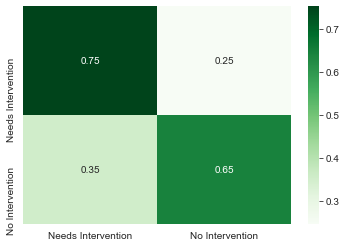

In [9]:
RFparams = {'n_estimators':[10,100,150],
           'criterion':['gini','entropy'],
           'max_depth':[4],
           'min_samples_split':[2,4,5],
           'oob_score':[True,False],
           'n_jobs':[-1],'random_state':[111],
           'max_samples':[.5,.7,None]}
           
RFgrid = GridSearchPresentationCV(RandomForestClassifier(), RFparams, scoring = 'f1', verbose = 1)

RFgrid.fit(train_df)

RFmodel = score_grid(RFgrid, X_test_transformed, y_test)
# pickle.dump(RFmodel, open('../models/RFmodel2.pkl','wb'))

### Random Forest Classifier Evaluation:
Apparently bagging is not the right approach to this problem.  Our single well tuned decision tree outperformed the random forest classifier.  I guess the wisdom of the crowd is not always superior to the wisdom of the expert!

# eXtreme Gradient Boost model:
XGBoost models have gained a lot of popularity recently and won a lot of Kaggle competitions.  It uses another popular idea called [boosting](https://en.wikipedia.org/wiki/Gradient_boosting).  That's a pretty involved wikipedia article, but the TLDR is that it's a similar ensemble method like random forest, but whereas random forest trains a bunch of trees in parallel and takes the aggregate of their predictions, boosting stacks the trees on top of each other and each one tries to improve on the one below it by predicting where the previous one made mistakes.  I think of it as like a line of morons each grading the next one's paper, which is an analysis of the previous one's paper.  Each one gets a lot wrong, but something right so the right answers percolate through and some of the wrong answers get corrected at each step.

In [ ]:
XGBparams = {'n_estimators':[200,300,400],
             'max_depth':[4],
             'learning_rate':[.1], 
             'subsample':[.7],
             'gamma':[1],
             'min_child_weight':[2,4],
             'num_parallel_tree':[2,3],
             'eval_metric':['logloss'],
            'colsample_bytree':[.8,.9,1],
            'base_score':[.4,.5,.6]}
           
XBGgrid = GridSearchPresentationCV(XGBClassifier(objective='binary:logistic', 
                                                 n_jobs=-1, random_state=111),
                                 XGBparams, scoring = 'f1', verbose = 1)
XBGgrid.fit(train_df)

XGBmodel = score_grid(XBGgrid, X_test_transformed, y_test)

# pickle.dump(XGBmodel, open('../models/XGBmodel4.pkl','wb'))

In [ ]:
plot_importance(XGBmodel, importance_type = 'gain')

## XGBoost evaluation:
XGBoost gave us the best cross-validated score of these four model types.  While it performs slightly worse on the validation set than the random forest, looking at the scores across folds, it seems likely that this represents the validation set being a sort of bad split.  XGBoost also performs equally well on both classes.  It correctly identifies 74% of students who need intervention to succeed, while misclassifying 27% of passing students as needing intervention.  

# SVM
An SVM, or support vector machine, attempts to draw a line, or hyperplane, between the classes to divide them.  This can be degree 2 polynomial line or higher, creating curved dividers of different shapes to match more complex decision boundaries.  It finds the best fit such hyperplane so as to maximize the distance between observations in a recursive manner.  EDA suggests that the observations can, to a large extent, be divided along the variables we have seen.  Decision trees, which do not operate this way, have been relatively successful, but let's see what this model, somewhat more closely related to the logistic regression, can do.

In [ ]:
SVCparams = {'C':[.01, .1, 1, 10, 100],
            'kernel':['linear','poly'],
             'degree':[3,4],
             'gamma':['auto', 'scale'],
             'tol':[1e-3],}
             
SVCgrid = GridSearchPresentationCV(SVC(random_state=111), SVCparams, 
                                scoring='f1', verbose = 1)

SVCgrid.fit(train_df)
SVCmodel = score_grid(SVCgrid, X_test_transformed, y_test)
# pickle.dump(SVCmodel, open('../models/SVCmodel1.pkl','wb'))

## SVM Evaluation
The SVM performed quite well.  It scored an overall accuracy of 77% with slight prediction bias toward 'No Intervention', in line with the other models.  

Different hyper parameters didn't make much difference to accuracy, except a polynomial kernel (degree 3) over predicted student success.  This would be the way to go if interventions are particularly costly.  If you biased the predictions that much toward 'No Intervention', you could be fairly certain that the students receiving interventions really need them.  The same results could also be achieved with the logistic regression model by setting the decision point of the sigmoid function toward the passing class, biasing the model.

## K-Nearest Neighbors
This model positions each observation (student registration in this case) from the training set in n_feature dimensional space.  New observations from the test set are voted on by the closest K observations from the training set to determine which class the new observation should belong to. There are two big benefits to this modeling technique for our dataset.  The first is that it is fast with few features.  We have only 6 features, so the dimensionality of the space is low, observations are more tightly packed, and the model makes determinations quickly.  The second benefit is that it is non-linear.  We've had some success with more linear models, and decision tree models.  Our error analysis and EDA show that there are strong linear relationships between our variables and the success of students.  However there is a solid 20% of students that cannot seem to be classified with these linear models.  The decision tree models similar seem to fail to classify these students.  Perhaps this model can help find where they belong.  

In [ ]:
KNNparams = {'n_neighbors':[30, 50, 100, 150],
            'weights':['distance', 'uniform'],
             'p':[2,3,4,5,6,7,8,9]}
             
KNNgrid = GridSearchPresentationCV(KNeighborsClassifier(n_jobs = -1), KNNparams, 
                                scoring='accuracy', verbose = 1)

KNNgrid.fit(train_df)
KNNmodel = score_grid(KNNgrid, X_test_transformed, y_test)
# pickle.dump(KNNmodel, open('../models/KNNmodel1.pkl','wb'))

### KNN Evaluation
This model, like the others, seems to top out around 77%.  We still haven't found a way to capture the pattern for how those last 20-23% of students fail or withdraw.  Looking at our error analysis from the final report notebook we see that those misclassfied students really look a lot like successful ones according to all of our variables.  It may just be that we don't have the right variable to find the connection.  We may be running up against the irreducible error for this feature set.

In [ ]:
RFmodel.fit(X_train_transformed,y_train_transformed)
y_pred = RFmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
DTmodel.fit(X_train_transformed,y_train_transformed)
y_pred = DTmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
LRmodel.fit(X_train_transformed,y_train_transformed)
y_pred = LRmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
SVCmodel.fit(X_train_transformed,y_train_transformed)
y_pred = SVCmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
XGBmodel.fit(X_train_transformed,y_train_transformed)
y_pred = XGBmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
KNNmodel.fit(X_train_transformed,y_train_transformed)
y_pred = KNNmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
eval_df = test_df
eval_df['prediction'] = y_pred
modules = eval_df['code_module'].unique()
course_acc = pd.DataFrame(columns = ['score'],index = modules)
fig, axes = plt.subplots(4,2, figsize = (10,10))
axes = axes.ravel()
for i, module in enumerate(modules):
    preds = eval_df[eval_df['code_module'] == module]['prediction']
    trues = eval_df[eval_df['code_module'] == module]['final_result']
    accuracy = accuracy_score(trues,preds)
    course_acc.loc[module,'score'] = accuracy
    plot_confusion(trues,preds, ax = axes[i])
    axes[i].set_title(f'{module}: {round(accuracy,2)}')
plt.tight_layout()
plt.show()

In [ ]:
module

In [ ]:
df[df['code_module'] == 'BBB'].groupby(by = 'code_presentation').count()